In [2]:
import os
import pandas as pd
import numpy as np

# ====== CONFIG: set your filenames here ======
# Put these CSV files under /content/ (Colab default)
DATASETS = {
    "Itihasa": "itihasa.csv",
    "Bible": "Bible.csv",
    "MKB": "mkb.csv",
    "Spoken-tutorials": "spoken-tutorials.csv",
    "Gitasopanam": "gitasopanam.csv",
}

# Domain descriptions for the paper table
DOMAINS = {
    "Itihasa": "Classical epic / poetry",
    "Bible": "Religious prose",
    "MKB": "Modern political speech",
    "Spoken-tutorials": "Technical instructional",
    "Gitasopanam": "Pedagogical / learner text",
}

BASE_DIR = "/content"

def count_whitespace_tokens(text: str) -> int:
    """Count tokens by whitespace; robust to NaN/None."""
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return 0
    text = str(text).strip()
    if not text:
        return 0
    return len(text.split())

rows = []

for name, fname in DATASETS.items():
    path = os.path.join(BASE_DIR, fname)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    df = pd.read_csv(path)

    # Try to find 'source' and 'target' columns robustly
    cols_lower = {c.lower(): c for c in df.columns}
    if "source" not in cols_lower or "target" not in cols_lower:
        raise ValueError(
            f"{fname} must contain columns named 'source' and 'target'. "
            f"Found columns: {list(df.columns)}"
        )

    src_col = cols_lower["source"]
    tgt_col = cols_lower["target"]

    # Drop rows where both are empty (optional but usually sensible)
    df[src_col] = df[src_col].astype(str)
    df[tgt_col] = df[tgt_col].astype(str)

    src_lens = df[src_col].apply(count_whitespace_tokens).to_numpy()
    tgt_lens = df[tgt_col].apply(count_whitespace_tokens).to_numpy()

    n_pairs = len(df)

    rows.append({
        "Dataset": name,
        "Domain": DOMAINS.get(name, ""),
        "#Pairs": n_pairs,
        "Src_mean": float(np.mean(src_lens)),
        "Src_std": float(np.std(src_lens, ddof=1)) if n_pairs > 1 else 0.0,
        "Tgt_mean": float(np.mean(tgt_lens)),
        "Tgt_std": float(np.std(tgt_lens, ddof=1)) if n_pairs > 1 else 0.0,
    })

stats_df = pd.DataFrame(rows)

# Pretty print in notebook
display(stats_df)

# Also print a compact text summary
print("\n=== Summary (mean ± std) ===")
for _, r in stats_df.iterrows():
    print(f"{r['Dataset']}: #={int(r['#Pairs'])} | "
          f"Src {r['Src_mean']:.2f}±{r['Src_std']:.2f} | "
          f"Tgt {r['Tgt_mean']:.2f}±{r['Tgt_std']:.2f}")

# ====== Generate LaTeX table ======
def fmt_pm(mean, std):
    return f"{mean:.2f}$\\pm${std:.2f}"

latex_lines = []
latex_lines.append("\\begin{table}[t]")
latex_lines.append("\\centering")
latex_lines.append("\\small")
latex_lines.append("\\begin{tabular}{l l r r r}")
latex_lines.append("\\hline")
latex_lines.append("\\textbf{Dataset} & \\textbf{Domain} & \\textbf{\\#Pairs} & "
                   "\\textbf{Src tok (mean$\\pm$std)} & \\textbf{Tgt tok (mean$\\pm$std)} \\\\")
latex_lines.append("\\hline")

# Keep a fixed order as in DATASETS
for ds_name in DATASETS.keys():
    r = stats_df[stats_df["Dataset"] == ds_name].iloc[0]
    line = (f"{r['Dataset']} & {r['Domain']} & {int(r['#Pairs'])} & "
            f"{fmt_pm(r['Src_mean'], r['Src_std'])} & {fmt_pm(r['Tgt_mean'], r['Tgt_std'])} \\\\")
    latex_lines.append(line)

latex_lines.append("\\hline")
latex_lines.append("\\end{tabular}")
latex_lines.append("\\caption{Statistics of the evaluation subsets. Token length is measured by whitespace-separated tokens for both source and target.}")
latex_lines.append("\\label{tab:data_stats}")
latex_lines.append("\\end{table}")

latex_table = "\n".join(latex_lines)

# Save LaTeX table to a file for easy copy/paste
out_path = "/content/table_data_stats.tex"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_table)

print(f"\nLaTeX table saved to: {out_path}\n")
print(latex_table)


,Dataset,Domain,#Pairs,Src_mean,Src_std,Tgt_mean,Tgt_std
0,Itihasa,Classical epic / poetry,100,10.86,3.908085,28.01,10.498191
1,Bible,Religious prose,100,12.24,5.390077,21.73,9.173804
2,MKB,Modern political speech,100,11.51,6.074446,18.10,9.492687
3,Spoken-tutorials,Technical instructional,100,9.01,4.258076,10.29,5.390405
4,Gitasopanam,Pedagogical / learner text,100,4.43,1.640738,5.82,2.819055



=== Summary (mean ± std) ===
Itihasa: #=100 | Src 10.86±3.91 | Tgt 28.01±10.50
Bible: #=100 | Src 12.24±5.39 | Tgt 21.73±9.17
MKB: #=100 | Src 11.51±6.07 | Tgt 18.10±9.49
Spoken-tutorials: #=100 | Src 9.01±4.26 | Tgt 10.29±5.39
Gitasopanam: #=100 | Src 4.43±1.64 | Tgt 5.82±2.82

LaTeX table saved to: /content/table_data_stats.tex

\begin{table}[t]
\centering
\small
\begin{tabular}{l l r r r}
\hline
\textbf{Dataset} & \textbf{Domain} & \textbf{\#Pairs} & \textbf{Src tok (mean$\pm$std)} & \textbf{Tgt tok (mean$\pm$std)} \\
\hline
Itihasa & Classical epic / poetry & 100 & 10.86$\pm$3.91 & 28.01$\pm$10.50 \\
Bible & Religious prose & 100 & 12.24$\pm$5.39 & 21.73$\pm$9.17 \\
MKB & Modern political speech & 100 & 11.51$\pm$6.07 & 18.10$\pm$9.49 \\
Spoken-tutorials & Technical instructional & 100 & 9.01$\pm$4.26 & 10.29$\pm$5.39 \\
Gitasopanam & Pedagogical / learner text & 100 & 4.43$\pm$1.64 & 5.82$\pm$2.82 \\
\hline
\end{tabular}
\caption{Statistics of the evaluation subsets. Token length

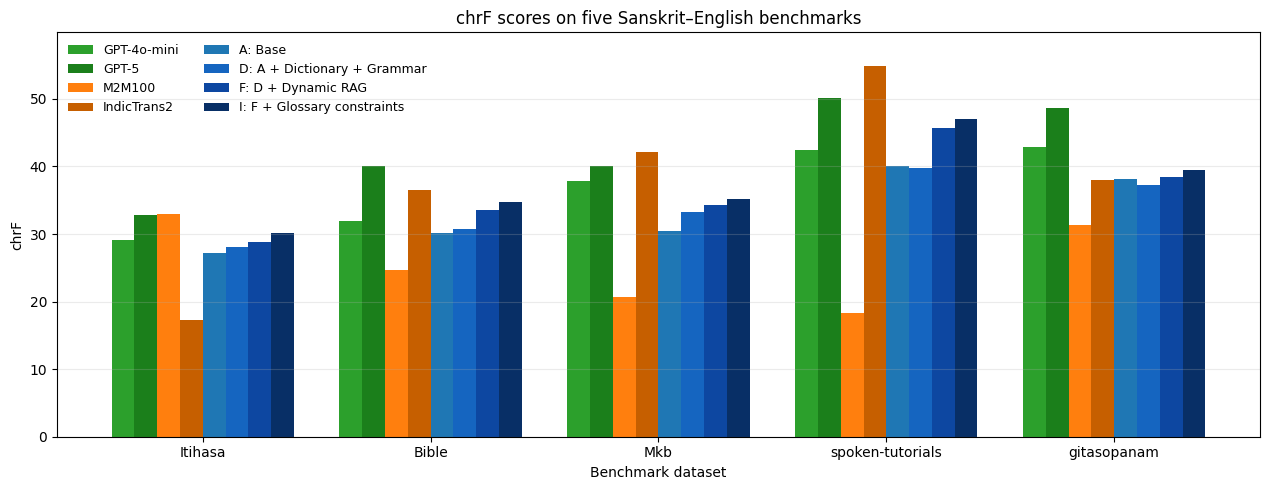

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reuse plot_df from previous cell if present; otherwise reload quickly
csv_path = "/content/Evaluation Results.csv"
raw = pd.read_csv(csv_path)

metric_row = raw.iloc[0].fillna("")
cols = raw.columns.tolist()

multi_cols = []
last_system = None
for c0, c1 in zip(cols, metric_row.tolist()):
    c0s = str(c0).strip()
    c1s = str(c1).strip()
    if c0s == "Unnamed: 0":
        multi_cols.append(("Dataset", ""))
        last_system = None
        continue
    if not c0s.startswith("Unnamed"):
        last_system = c0s
        multi_cols.append((last_system, c1s if c1s else ""))
        continue
    if last_system is not None and c1s in {"BLEU", "chrF"}:
        multi_cols.append((last_system, c1s))
    else:
        multi_cols.append(("__spacer__", "__spacer__"))

df = raw.drop(index=0).copy()
df.columns = pd.MultiIndex.from_tuples(multi_cols)
df = df.loc[:, df.columns.get_level_values(0) != "__spacer__"]

df[("Dataset","")] = df[("Dataset","")].astype(str).str.strip()
for col in df.columns:
    if col[0] != "Dataset":
        df[col] = pd.to_numeric(df[col], errors="coerce")

systems_order = [
    "GPT4o-mini", "GPT5",
    "M2M100_Sanskrit_English", "indictrans2",
    "A", "D", "F", "I"
]
plot_df = pd.DataFrame({"Dataset": df[("Dataset","")].values})
for s in systems_order:
    plot_df[s] = df[(s, "chrF")].values

# Legend-friendly labels (short but informative)
labels = {
    "GPT4o-mini": "GPT-4o-mini",
    "GPT5": "GPT-5",
    "M2M100_Sanskrit_English": "M2M100",
    "indictrans2": "IndicTrans2",
    "A": "A: Base",
    "D": "D: A + Dictionary + Grammar",
    "F": "F: D + Dynamic RAG",
    "I": "I: F + Glossary constraints",
}

# Color scheme families
colors = {
    "GPT4o-mini": "#2ca02c",
    "GPT5": "#1b7f1b",
    "M2M100_Sanskrit_English": "#ff7f0e",
    "indictrans2": "#c65f00",
    "A": "#1f77b4",
    "D": "#1565c0",
    "F": "#0d47a1",
    "I": "#082f66",
}

datasets = plot_df["Dataset"].tolist()
x = np.arange(len(datasets))
bar_width = 0.10
n_bars = len(systems_order)
offsets = (np.arange(n_bars) - (n_bars - 1)/2) * bar_width

plt.figure(figsize=(12.8, 5.0))
for i, s in enumerate(systems_order):
    plt.bar(
        x + offsets[i],
        plot_df[s],
        width=bar_width,
        label=labels[s],
        color=colors[s],
    )

plt.xticks(x, datasets)
plt.ylabel("chrF")
plt.xlabel("Benchmark dataset")
plt.ylim(0, float(np.nanmax(plot_df[systems_order].values)) + 5)

plt.title("chrF scores on five Sanskrit–English benchmarks")
plt.legend(ncol=2, frameon=False, fontsize=9)  # 2 columns for longer labels
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

In [ ]:
# 可选：打印用于作图的数据表（方便你写论文/复查）
plot_df

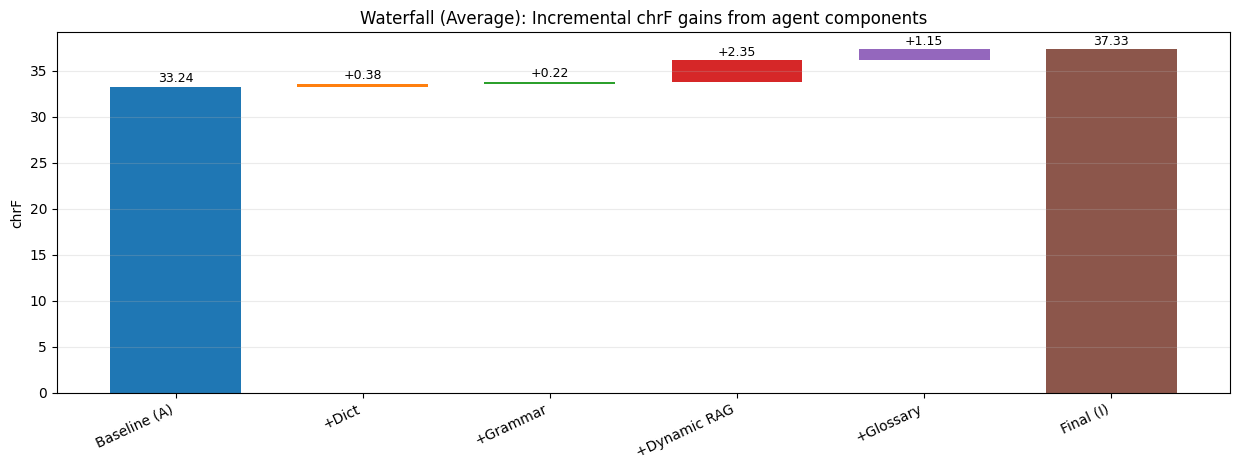

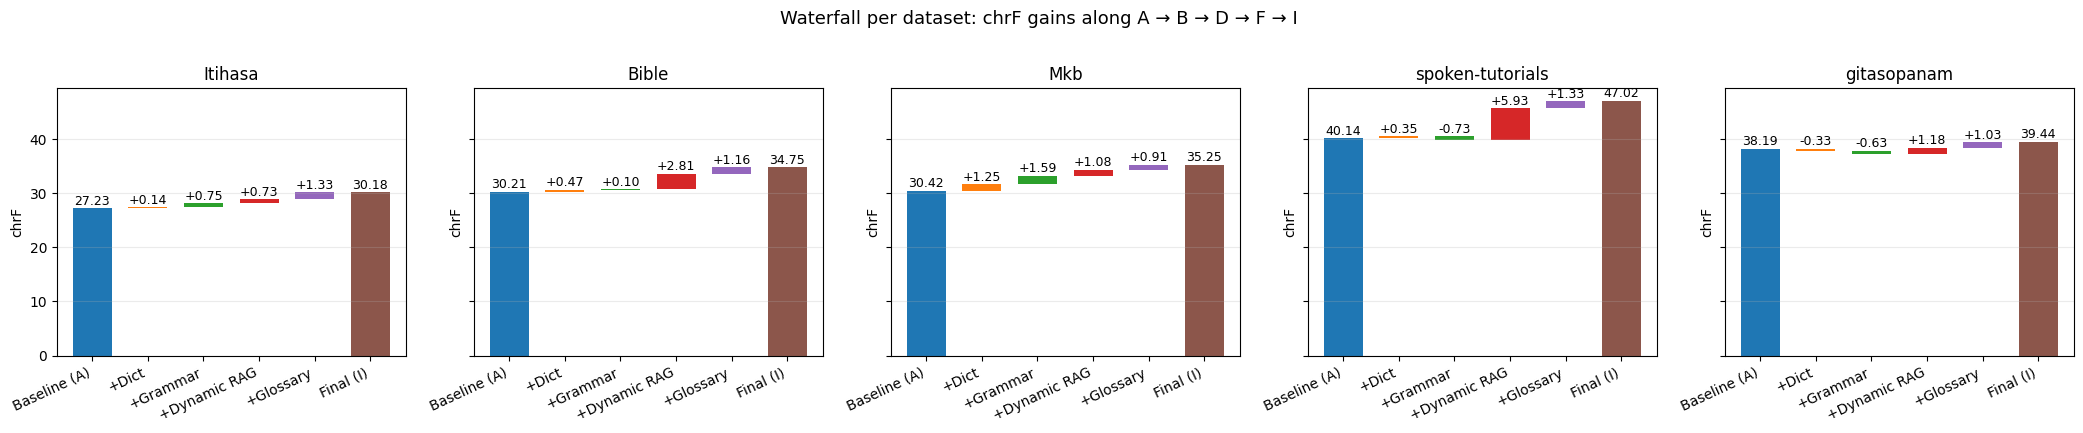

,Dataset,A,B,D,F,I,d_dict,d_gram,d_rag,d_gloss
0,Itihasa,27.23,27.37,28.12,28.85,30.18,0.14,0.75,0.73,1.33
1,Bible,30.21,30.68,30.78,33.59,34.75,0.47,0.10,2.81,1.16
2,Mkb,30.42,31.67,33.26,34.34,35.25,1.25,1.59,1.08,0.91
3,spoken-tutorials,40.14,40.49,39.76,45.69,47.02,0.35,-0.73,5.93,1.33
4,gitasopanam,38.19,37.86,37.23,38.41,39.44,-0.33,-0.63,1.18,1.03


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ========= 1) Load & parse the same CSV =========
csv_path = "/content/Evaluation Results.csv"
raw = pd.read_csv(csv_path)

metric_row = raw.iloc[0].fillna("")
cols = raw.columns.tolist()

multi_cols = []
last_system = None
for c0, c1 in zip(cols, metric_row.tolist()):
    c0s = str(c0).strip()
    c1s = str(c1).strip()

    if c0s == "Unnamed: 0":
        multi_cols.append(("Dataset", ""))
        last_system = None
        continue

    if not c0s.startswith("Unnamed"):
        last_system = c0s
        multi_cols.append((last_system, c1s if c1s else ""))
        continue

    if last_system is not None and c1s in {"BLEU", "chrF"}:
        multi_cols.append((last_system, c1s))
    else:
        multi_cols.append(("__spacer__", "__spacer__"))

df = raw.drop(index=0).copy()
df.columns = pd.MultiIndex.from_tuples(multi_cols)
df = df.loc[:, df.columns.get_level_values(0) != "__spacer__"]

df[("Dataset","")] = df[("Dataset","")].astype(str).str.strip()
for col in df.columns:
    if col[0] != "Dataset":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# ========= 2) Build table for waterfall (chrF only) =========
needed = ["A", "B", "D", "F", "I"]
missing = [s for s in needed if s not in set(df.columns.get_level_values(0))]
if missing:
    raise ValueError(f"Missing required systems for waterfall: {missing}")

water = pd.DataFrame({
    "Dataset": df[("Dataset","")].values,
    "A": df[("A","chrF")].values,
    "B": df[("B","chrF")].values,
    "D": df[("D","chrF")].values,
    "F": df[("F","chrF")].values,
    "I": df[("I","chrF")].values,
})

# Incremental gains
water["d_dict"]  = water["B"] - water["A"]   # +Dict
water["d_gram"]  = water["D"] - water["B"]   # +Grammar (on top of Dict)
water["d_rag"]   = water["F"] - water["D"]   # +Dynamic RAG
water["d_gloss"] = water["I"] - water["F"]   # +Glossary

# Average across datasets (main waterfall)
avg = water[["A","d_dict","d_gram","d_rag","d_gloss","I"]].mean(numeric_only=True)

# ========= 3) Helper: plot a single waterfall =========
def plot_waterfall(ax, base, deltas, final, title):
    steps = ["Baseline (A)", "+Dict", "+Grammar", "+Dynamic RAG", "+Glossary", "Final (I)"]
    x = np.arange(len(steps))

    # Base bar
    ax.bar(0, base, width=0.7)
    ax.text(0, base + 0.2, f"{base:.2f}", ha="center", va="bottom", fontsize=9)

    # Delta bars (cumulative)
    running = base
    for i, d in enumerate(deltas, start=1):
        bottom = running if d >= 0 else running + d
        ax.bar(i, abs(d), bottom=bottom, width=0.7)
        ax.text(i, bottom + abs(d) + 0.15, f"{d:+.2f}", ha="center", va="bottom", fontsize=9)
        running += d

    # Final bar
    ax.bar(len(steps)-1, final, width=0.7)
    ax.text(len(steps)-1, final + 0.2, f"{final:.2f}", ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(steps, rotation=25, ha="right")
    ax.set_ylabel("chrF")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.25)

# ========= 4) Figure W1: Average waterfall =========
base_avg = float(avg["A"])
deltas_avg = [float(avg["d_dict"]), float(avg["d_gram"]), float(avg["d_rag"]), float(avg["d_gloss"])]
final_avg = float(avg["I"])

plt.figure(figsize=(12.5, 4.8))
ax = plt.gca()
plot_waterfall(
    ax,
    base=base_avg,
    deltas=deltas_avg,
    final=final_avg,
    title="Waterfall (Average): Incremental chrF gains from agent components"
)
plt.tight_layout()
plt.show()

# ========= 5) Figure W2: Per-dataset small multiples =========
datasets = water["Dataset"].tolist()
n = len(datasets)

fig, axes = plt.subplots(1, n, figsize=(4.2*n, 4.2), sharey=True)
for i, ds in enumerate(datasets):
    row = water.iloc[i]
    base = float(row["A"])
    deltas = [float(row["d_dict"]), float(row["d_gram"]), float(row["d_rag"]), float(row["d_gloss"])]
    final = float(row["I"])
    plot_waterfall(axes[i], base, deltas, final, title=ds)

fig.suptitle("Waterfall per dataset: chrF gains along A → B → D → F → I", y=1.02, fontsize=13)
plt.tight_layout()
plt.show()

# Optional: inspect computed deltas
water[["Dataset","A","B","D","F","I","d_dict","d_gram","d_rag","d_gloss"]]
